## Import Library

Pada bagian ini, kita mengimpor berbagai library yang diperlukan untuk analisis dan pemrosesan data. Berikut adalah deskripsi singkat dari masing-masing library yang digunakan:

In [1]:
import pandas as pd
import re
import nltk
from google.colab import drive
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [2]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Load Dataset

In [3]:
# Load dataset
df = pd.read_csv('bca_reviews_balanced.csv')

## Tahap Preprocessing

Pada tahap preprocessing, kita melakukan beberapa langkah untuk membersihkan dan mempersiapkan data sebelum digunakan dalam model machine learning. Berikut adalah penjelasan dari setiap langkah yang dilakukan:

1. **Pembersihan Teks**:
    - Mengubah teks menjadi huruf kecil.
    - Menghapus URL dan karakter non-alfabet.
    - Menghapus spasi berlebih dan karakter yang tidak diperlukan.

2. **Penghapusan Komentar Tidak Relevan**:
    - Menghapus komentar yang terlalu panjang (lebih dari 200 karakter).
    - Menghapus komentar yang hanya terdiri dari tanda baca.
    - Menghapus komentar yang mirip dengan judul seperti "gacor", "witdraw", dll.
    - Menghapus komentar yang hanya terdiri dari satu atau beberapa kata saja.

3. **Tokenisasi dan Stemming**:
    - Melakukan stemming pada kata-kata dalam komentar untuk mengurangi kata ke bentuk dasarnya.

4. **Pemberian Label Otomatis**:
    - Memberikan label "positive", "negative", atau "neutral" pada komentar berdasarkan kata-kata yang ada dalam komentar tersebut.

5. **Encoding Label**:
    - Mengubah label kategori menjadi angka menggunakan `LabelEncoder`.

Tahap preprocessing ini sangat penting untuk memastikan data yang digunakan dalam model machine learning bersih dan relevan, sehingga dapat meningkatkan akurasi dan performa model.

In [4]:
stemmer = PorterStemmer()
stop_words_en = set(stopwords.words('english'))
stop_words_id = set(stopwords.words('indonesian'))
stop_words = stop_words_en.union(stop_words_id)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

df['content'] = df['content'].astype(str).apply(clean_text)

In [5]:
print(f'Sisa data setelah penghapusan: {len(df)} baris')

Sisa data setelah penghapusan: 14827 baris


In [6]:
# Encoding label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [7]:
X = df['content'].values.reshape(-1, 1)
y = df['label']

In [8]:
label_counts = df['label'].value_counts()
print(label_counts)

label
1    5375
2    4726
0    4726
Name: count, dtype: int64


In [9]:
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
for i in range(3):
    print(f'Label {i} is mapped to category: {label_mapping[i]}')

Label 0 is mapped to category: negative
Label 1 is mapped to category: neutral
Label 2 is mapped to category: positive


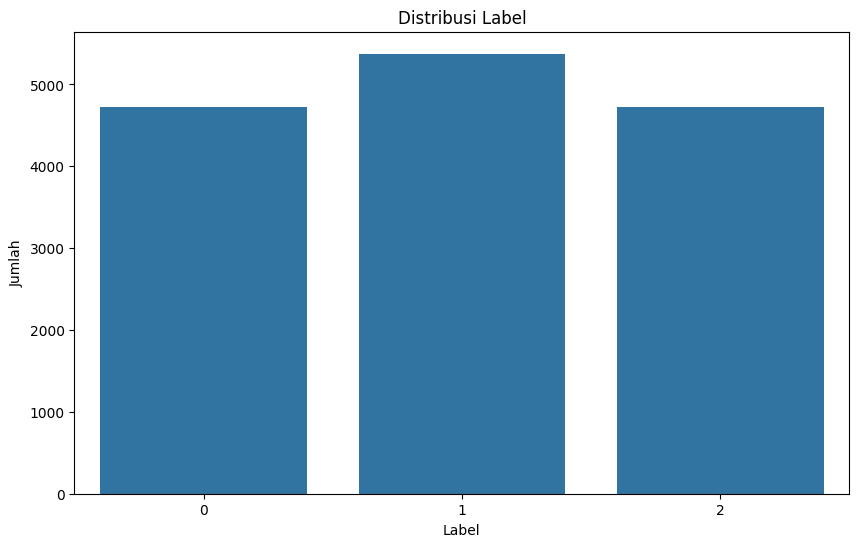

In [10]:
# Plot distribusi label
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

## Eksperimen 1: LSTM + Tokenizer + Pembagian Data 80/20

Pada eksperimen pertama ini, kita menggunakan model LSTM (Long Short-Term Memory) dengan tokenizer untuk memproses data teks. Berikut adalah langkah-langkah yang dilakukan:

1. **Pembagian Data**:
    - Data dibagi menjadi dua bagian: 80% untuk data latih dan 20% untuk data uji.
    - Pembagian ini dilakukan secara stratified untuk memastikan distribusi label yang sama di kedua set data.

2. **Tokenisasi**:
    - Menggunakan tokenizer dengan jumlah kata maksimal 10.000 dan token khusus untuk kata yang tidak dikenal (`<OOV>`).
    - Tokenizer ini dilatih pada data latih untuk membuat indeks kata.

3. **Pembuatan Sequence dan Padding**:
    - Data teks diubah menjadi sequence angka berdasarkan indeks kata yang dihasilkan oleh tokenizer.
    - Sequence ini kemudian dipadatkan (padding) hingga panjang maksimal 150 kata.

4. **Arsitektur Model**:
    - Model menggunakan embedding layer dengan dimensi 256.
    - Spatial dropout diterapkan pada embedding layer untuk regularisasi.
    - Dua layer BiLSTM (Bidirectional LSTM) digunakan, masing-masing dengan 128 dan 64 unit.
    - Batch normalization diterapkan setelah layer BiLSTM kedua.
    - Dua dense layer dengan 64 dan 32 unit digunakan sebelum output layer.
    - Output layer menggunakan softmax activation untuk klasifikasi multi-kelas.

5. **Optimisasi dan Pelatihan**:
    - Optimizer Adam dengan learning rate 0.001 digunakan.
    - Callbacks seperti ReduceLROnPlateau dan EarlyStopping digunakan untuk meningkatkan pelatihan.
    - Class weights dihitung untuk menangani ketidakseimbangan kelas.
    - Model dilatih selama 10 epoch dengan batch size 16.

6. **Evaluasi**:
    - Model dievaluasi pada data latih dan data uji untuk menghitung akurasi.
    - Hasil akurasi dilaporkan untuk kedua set data.

Eksperimen ini bertujuan untuk mengevaluasi performa model LSTM dengan tokenizer dan pembagian data 80/20.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [12]:
# Konversi ke list string jika perlu
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()

In [13]:
#Meningkatkan tokenizer dengan lebih banyak kata
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [14]:
#Meningkatkan panjang maksimal sequence
max_length = 150
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

model1 = Sequential([
    Embedding(input_dim=10000, output_dim=256, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
#Callbacks untuk pelatihan yang lebih baik
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [16]:
#Pelatihan dengan lebih banyak epoch dan callbacks
history = model1.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_test_padded, y_test),
    batch_size=16,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

Epoch 1/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.6688 - loss: 0.7266 - val_accuracy: 0.8581 - val_loss: 0.3954 - learning_rate: 0.0010
Epoch 2/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.8876 - loss: 0.3137 - val_accuracy: 0.8796 - val_loss: 0.3440 - learning_rate: 0.0010
Epoch 3/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - accuracy: 0.9244 - loss: 0.2252 - val_accuracy: 0.8672 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 4/10
741/742 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9381 - loss: 0.1681
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
742/742 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.9381 - loss: 0.1681 - val_accuracy: 0.8786 - val_loss: 0.3880 - learning_rate: 0.0010
Epoch 5/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.9600 - loss: 0.1206 - val_accuracy: 0.8800 - val_loss: 0.4090 - learning_rate: 2.0000e-04
Epoch 6/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9677 -

In [17]:
model1.save('LSTM+Tokenizer.h5')

train_loss, train_accuracy = model1.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model1.evaluate(X_test_padded, y_test)

371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9389 - loss: 0.1727
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8696 - loss: 0.3665


In [18]:
print(f'Experiment 1 Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Experiment 1 Testing Accuracy: {test_accuracy * 100:.2f}%')

Experiment 1 Training Accuracy: 93.76%
Experiment 1 Testing Accuracy: 87.96%


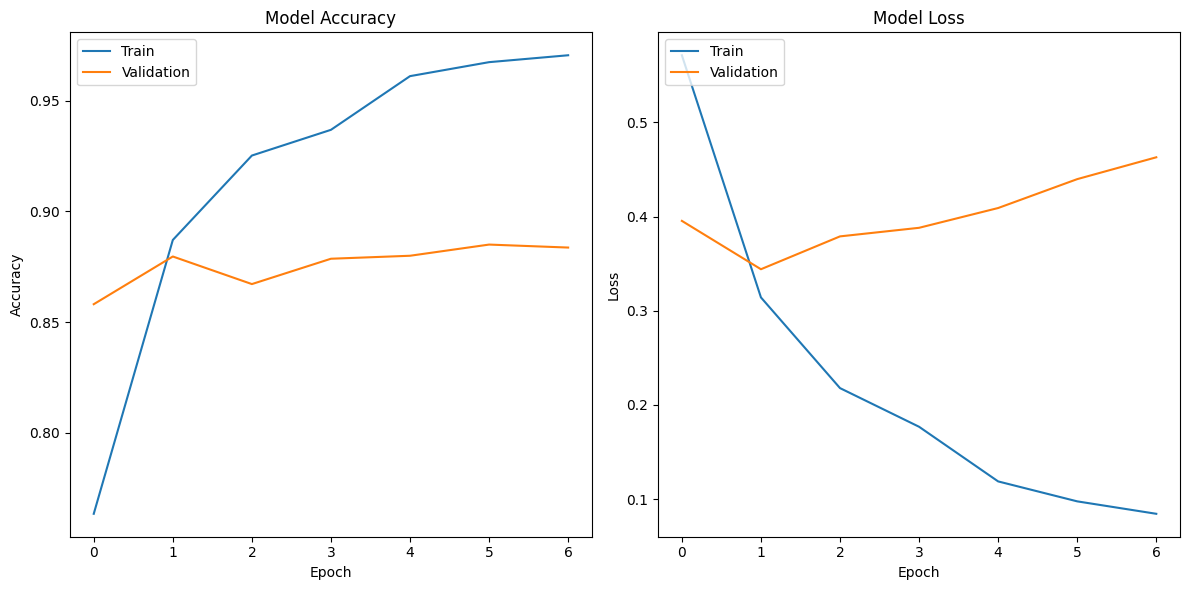

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Eksperimen 2: LSTM + Tokenizer + Pembagian Data 70/30

Pada eksperimen kedua ini, kita menggunakan model LSTM (Long Short-Term Memory) dengan tokenizer untuk memproses data teks. Berikut adalah langkah-langkah yang dilakukan:

1. **Pembagian Data**:
    - Data dibagi menjadi dua bagian: 70% untuk data latih dan 30% untuk data uji.
    - Pembagian ini dilakukan secara stratified untuk memastikan distribusi label yang sama di kedua set data.

2. **Tokenisasi**:
    - Menggunakan tokenizer dengan jumlah kata maksimal 5.000 dan token khusus untuk kata yang tidak dikenal (`<OOV>`).
    - Tokenizer ini dilatih pada data latih untuk membuat indeks kata.

3. **Pembuatan Sequence dan Padding**:
    - Data teks diubah menjadi sequence angka berdasarkan indeks kata yang dihasilkan oleh tokenizer.
    - Sequence ini kemudian dipadatkan (padding) hingga panjang maksimal 100 kata.

4. **Arsitektur Model**:
    - Model menggunakan embedding layer dengan dimensi 128.
    - Spatial dropout diterapkan pada embedding layer untuk regularisasi.
    - Satu layer BiLSTM (Bidirectional LSTM) digunakan dengan 64 unit.
    - Satu dense layer dengan 32 unit digunakan sebelum output layer.
    - Output layer menggunakan softmax activation untuk klasifikasi multi-kelas.

5. **Optimisasi dan Pelatihan**:
    - Optimizer Adam dengan learning rate 0.001 digunakan.
    - Callbacks seperti EarlyStopping digunakan untuk meningkatkan pelatihan.
    - Class weights dihitung untuk menangani ketidakseimbangan kelas.
    - Model dilatih selama 10 epoch dengan batch size 32.

6. **Evaluasi**:
    - Model dievaluasi pada data latih dan data uji untuk menghitung akurasi.
    - Hasil akurasi dilaporkan untuk kedua set data.

Eksperimen ini bertujuan untuk mengevaluasi performa model LSTM dengan tokenizer dan pembagian data 70/30.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['label'], test_size=0.3, random_state=42, stratify=df['label']
)

In [22]:
# Konversi ke string dan tokenisasi
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()

In [23]:
# Tokenizer dengan vocabulary yang lebih kecil namun cukup
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [24]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [25]:
# Panjang sequence yang lebih pendek
max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [26]:
# Model yang disederhanakan namun efektif
model2 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# Optimizer dengan learning rate yang sesuai
optimizer = Adam(learning_rate=0.001)
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [28]:
# Callbacks yang lebih sederhana
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [29]:
# Class weights untuk menangani ketidakseimbangan kelas (jika ada)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [30]:
# Training dengan batch size yang lebih besar untuk kecepatan
history = model2.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_test_padded, y_test),
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5901 - loss: 0.8383 - val_accuracy: 0.8550 - val_loss: 0.3808
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8827 - loss: 0.3276 - val_accuracy: 0.8771 - val_loss: 0.3294
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9204 - loss: 0.2224 - val_accuracy: 0.8788 - val_loss: 0.3486
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9365 - loss: 0.1818 - val_accuracy: 0.8757 - val_loss: 0.3547
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9453 - loss: 0.1513 - val_accuracy: 0.8721 - val_loss: 0.4111
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9522 - loss: 0.1380 - val_accuracy: 0.8721 - val_loss: 0.4008
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [31]:
model2.save('LSTM+Word2Vec.h5')

train_loss, train_accuracy = model2.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model2.evaluate(X_test_padded, y_test)

325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9519 - loss: 0.1453
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8823 - loss: 0.3454


In [32]:
print(f'Experiment 2 Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Experiment 2 Testing Accuracy: {test_accuracy * 100:.2f}%')

Experiment 2 Training Accuracy: 94.71%
Experiment 2 Testing Accuracy: 87.88%


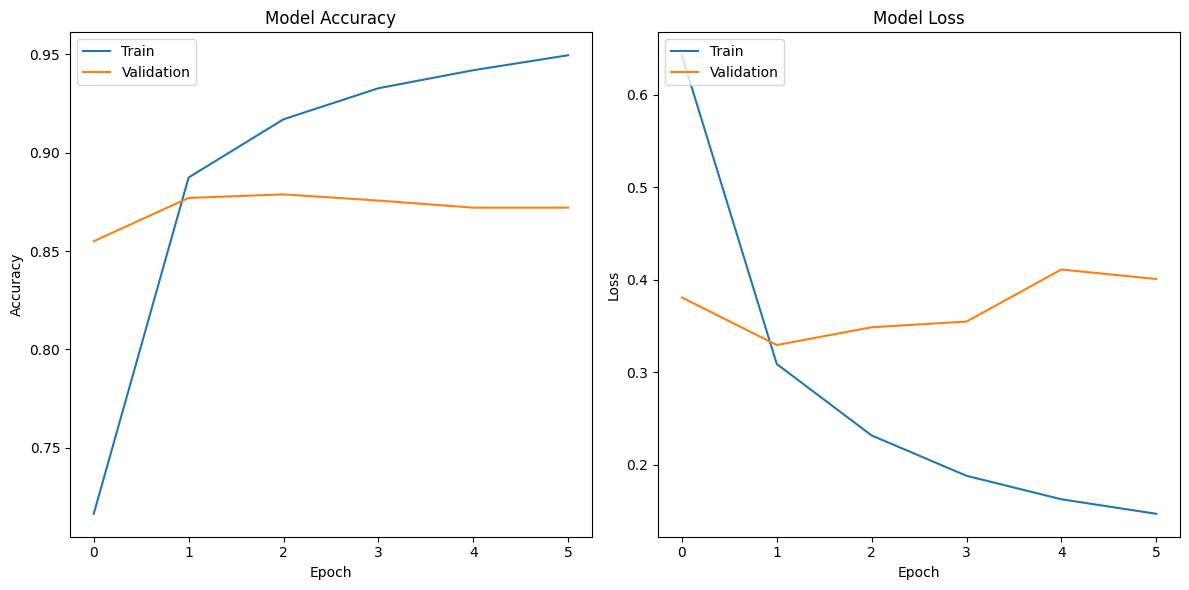

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Eksperimen 3: BiLSTM + GloVe + Pembagian Data 75/25

Pada eksperimen ketiga ini, kita menggunakan model BiLSTM (Bidirectional Long Short-Term Memory) dengan embedding GloVe (Global Vectors for Word Representation) dan pembagian data 75/25. Berikut adalah langkah-langkah yang dilakukan:

1. **Pembagian Data**:
	- Data dibagi menjadi dua bagian: 75% untuk data latih dan 25% untuk data uji.
	- Pembagian ini dilakukan secara stratified untuk memastikan distribusi label yang sama di kedua set data.

2. **Tokenisasi**:
	- Menggunakan tokenizer dengan jumlah kata maksimal 10.000 dan token khusus untuk kata yang tidak dikenal (`<OOV>`).
	- Tokenizer ini dilatih pada data latih untuk membuat indeks kata.

3. **Pembuatan Sequence dan Padding**:
	- Data teks diubah menjadi sequence angka berdasarkan indeks kata yang dihasilkan oleh tokenizer.
	- Sequence ini kemudian dipadatkan (padding) hingga panjang maksimal 150 kata.

4. **Arsitektur Model**:
	- Model menggunakan embedding layer dengan dimensi 256.
	- Spatial dropout diterapkan pada embedding layer untuk regularisasi.
	- Tiga layer BiLSTM digunakan, masing-masing dengan 128, 64, dan 32 unit.
	- Batch normalization diterapkan setelah setiap layer BiLSTM.
	- Dua dense layer dengan 128 dan 64 unit digunakan sebelum output layer.
	- Output layer menggunakan softmax activation untuk klasifikasi multi-kelas.

5. **Optimisasi dan Pelatihan**:
	- Optimizer Adam dengan learning rate 0.0005 digunakan.
	- Callbacks seperti ReduceLROnPlateau dan EarlyStopping digunakan untuk meningkatkan pelatihan.
	- Model dilatih selama 10 epoch dengan batch size 16.

6. **Evaluasi**:
	- Model dievaluasi pada data latih dan data uji untuk menghitung akurasi.
	- Hasil akurasi dilaporkan untuk kedua set data.

Eksperimen ini bertujuan untuk mengevaluasi performa model BiLSTM dengan embedding GloVe dan pembagian data 75/25.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['label'],
    test_size=0.25,
    random_state=42,
    stratify=df['label']
)

In [35]:
# Memperbesar vocabulary dan menggunakan out-of-vocabulary token
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Menggunakan max_length yang lebih panjang
max_length = 150
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [36]:
# Model yang dioptimasi
model_optimized = Sequential([
    Embedding(input_dim=10000, output_dim=256, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=False)),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
# Optimizer dengan learning rate yang lebih rendah
optimizer = Adam(learning_rate=0.0005)

model_optimized.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callbacks untuk meningkatkan training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

In [38]:
# Training dengan lebih banyak epochs
history = model_optimized.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_test_padded, y_test),
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - accuracy: 0.5757 - loss: 0.9277 - val_accuracy: 0.7505 - val_loss: 0.6881 - learning_rate: 5.0000e-04
Epoch 2/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.8536 - loss: 0.3922 - val_accuracy: 0.8608 - val_loss: 0.3740 - learning_rate: 5.0000e-04
Epoch 3/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9125 - loss: 0.2670 - val_accuracy: 0.8584 - val_loss: 0.4067 - learning_rate: 5.0000e-04
Epoch 4/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.9304 - loss: 0.2032 - val_accuracy: 0.8640 - val_loss: 0.4069 - learning_rate: 5.0000e-04
Epoch 5/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9461 - loss: 0.1549
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
695/695 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.9461 - loss: 0.1549 - val_accuracy: 0.8751 - val_loss: 0.3995 - learning_rate: 5.0000e-04
Epoch 6/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - ac

In [39]:
model_optimized.save('BiLSTM+GloVe.h5')

train_loss, train_accuracy = model_optimized.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model_optimized.evaluate(X_test_padded, y_test)

348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9656 - loss: 0.0984
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8734 - loss: 0.3952


In [40]:
print(f'Optimized Model Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Optimized Model Testing Accuracy: {test_accuracy * 100:.2f}%')

Optimized Model Training Accuracy: 96.89%
Optimized Model Testing Accuracy: 87.51%


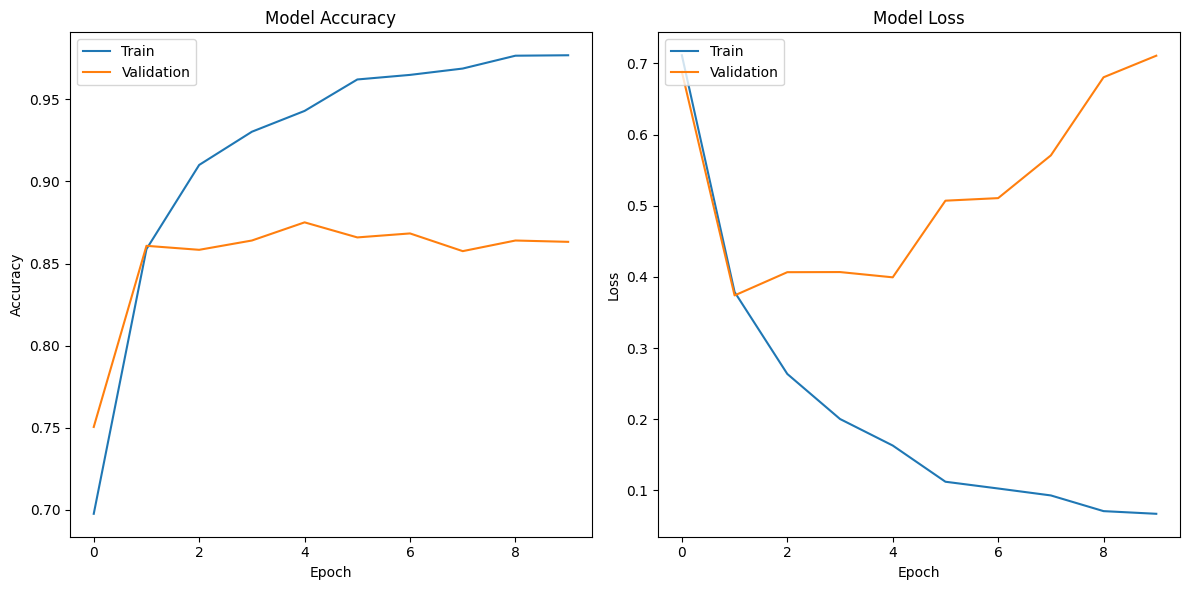

In [41]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()